In [1]:
# http://detexify.kirelabs.org/classify.html
## Libreria de control
try:
  from control.matlab import *
except:
  !pip install control
  from control.matlab import *
    
## Libreria para graphicar
import matplotlib.pyplot as plt
import numpy as np

## Libreria para calculo simbolico
import sympy

## Libreria de control
import control

## Libreria para widgets
import ipywidgets as widgets

## Libreria para animaciones
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "html5"#"jshtml"

## Libreria para importar Iframe de Youtube
from IPython.display import IFrame

# Recordando los comportamientos

Usemos teoría de control para describir lo que ocurre en la imagen:

![](robot-obstaculo-objetivo.png)

- Llegar al objetivo
- Evitar el obstaculo

# Empecemos por el modelo

Para el proposito de planear asumamos el modelo de una particula controlada en velocidad en el plano $xy$:

$$\dot{x}=u\quad,\quad x\in\mathscr{R}^2$$

cuya representación en espacio de estados es:

$$\dot{x} = \left[\array{0&0\\0&0}\right]x+\left[\array{1&0\\0&1}\right]u$$

¿es este sistema controlable?

$$\Gamma = \left[\array{B&AB}\right]=\left[\array{I&0}\right]$$

$$\text{rank}\left(\Gamma\right) = 2$$

# El duo dinámico

Los comportamiento principales en una plataforma movil son:

- Ir al objetivo: El robot se dirige hacia el objetivo.
- Evita obstaculos: No te golpes contra las cosas.

Tarea en el diseño del controlador:

- Seleccionar el vector de movimiento deseado y definirlo como la velocidad del vehículo. 

![](robot-to-goal.png)

# Ir al objetivo

![](robot-go-to-goal.png)

$$u=Ke \qquad\to\qquad \dot{e}=0-\dot{x}=-Ke$$

¿Es asintoticamente estable? 

$$K>0 \quad\text{o}\quad K\succ0 \quad\{\text{eig}(K)>0\}$$

$$e\to 0$$

# Una preocupación

- Un controlador lineal significa que el robot va más rápido entre más lejos del objetivo este.
- Una solución en la práctica: Hacemos la ganancia $K$ una función de $e$:

$$\dot{e}=-K(\parallel e\parallel)e$$

considerando $K$ de la siguiente forma:

$$K = v_0 \frac{1-e^{-\alpha\parallel e\parallel^2}}{\parallel e\parallel}$$

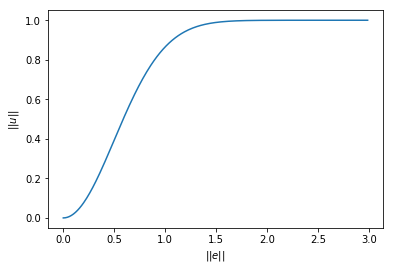

In [15]:
alpha = 2
v0    = 1
e     = np.arange(0,3,0.01)
K     = v0 * (1-np.exp(-alpha*e*e))
plt.plot(e,K);
plt.ylabel("$||u||$");
plt.xlabel("$||e||$");

# Evitar obstaculos

![](robot-avoid-obstacle.png)

$$u=Ke \quad\to\quad \dot{e}=Ke$$

Comportamiento inestable!

# Más preocupaciones

- El robot se va al infinito?
- Esta siendo demasiado cauteloso?
- Nos importa menos si estamos más cerca?

## Soluciones

- Hacer $K$ dependiente de e
- Cambiar entre los comportamientos
- Usar el modo inducido

# Para evitar obstaculos

Cosideremos la siguiente $K$ dependiente del error $e$:

$$K = \frac{1}{\parallel e\parallel}\left(\frac{c}{\parallel e\parallel^2 +\epsilon}\right)$$

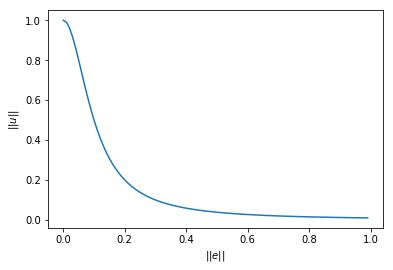

In [18]:
c          = 0.01
epsilon    = 0.01
e          = np.arange(0,1,0.01)
K          = c / (e*e + epsilon)
plt.plot(e,K);
plt.ylabel("$||u||$");
plt.xlabel("$||e||$");

# Transiciones entre modos o comportamientos

- ¿Cómo acoplar la dinámica del robot con los comportamientos?
- ¿Cuáles deben ser las transiciones?

# Cambios bruscos o difuminado

Dados dos comportamientos diferentes, como debemos combinarlos ?

![](robot-behavior-switch.png)

- Cambios bruscos
- Interpolación / difuminado

# Ventajas y desventajas

## Cambios bruscos

- **Ventaja**: Comportamiento garantizado.
- **Desventaja**: Movimientos bruscos y posible zeno.

## Modo Combinado

- **Ventaja**: Movimiento suave.
- **Desventaja**: No hay garantias. 

# Posibilidad #1 : Autómata Híbrido

![](robot-ha.png)

# Posibilidad #2 : Modo combinado

![](robot-blending.png)

$$\sigma(d_o) \in [0,1]$$

$$\dot{x}=\sigma(d_o)u_{GTG}+(1-\sigma(d_o))u_{AO}$$

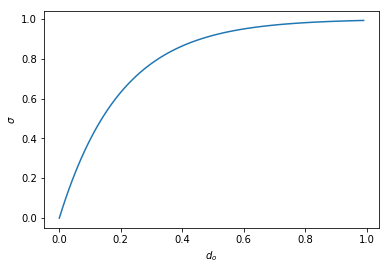

In [25]:
beta       = 5
do         = np.arange(0,1,0.01)
sigma      = 1-np.exp(-beta*do)
plt.plot(do,sigma);
plt.xlabel("$d_o$");
plt.ylabel("$\sigma$");

# Comentarios

- Dos elecciones, cada uno con ventajas y desventajas
- Que bueno sería tener las ventajas de ambas posibilidades: movimiento suave y desempeño garantizado
- Usaremos del modo inducido

# Mundos convexos y no convexos

Veamos cuando nuestros dos comportamientos son suficientes y cuando necesitamos agregar más comportamientos. 

De un mundo simple a un mundo complejo tenemos:

1. El mundo de los puntos.
2. El mundo de los circulos.
3. El mundo de objetos convexos.
4. El mundo de objetos no convexos.
5. El mundo de los laberintos. 

# El mundo de los puntos

![](world-points.png)

- Aquí los dos comportamientos son suficientes a menos que seamos muy de malas. 
- El problema es que podemos entrar en un Zenon.
- La solución es agregar algo de ruido. En práctica siempre tendremos ruido. 

# El mundo de los circulos

![](world-circles.png)

- Es igual al mundo de los puntos

# Obstaculos convexos

![](convex-non-convex.png)

Un obstaculo es convexo si cada linea trazada entre dos puntos al interior del obstaculo queda dentro del obstaculo.

# El mundo de objetos convexos

![](world-convex.png)

# El mundo de objetos no convexos

![](world-non-convex.png)

# El mundo de los laberintos

![](world-labyrinth.png)

# Otro comportamiento

Necesitamos otro comportamiento para lidiar con estos mundos que tienen obstaculos no convexos. 

# Seguir el muro

- Necesitamos una forma de lidiar con ambientes complejos.
- Un comportamiento muy útil es hacer que el robot siga la frontera de un obstaculo o muro.
- Esto también nos permite introducir el modo inducido en de forma más sistematica. 

# Cómo seguir un muro

- El comportamiento de seguir un muro debe mantener una distancia constante entre el robot y el obstaculo/muro. 

![](robot-follow-wall.png)

$$u_{FW} = \alpha \left[\array{0&1\\-1&0}\right]u_{AO} = \alpha R(-\pi/2) u_{AO}$$

# Seguimos el muro de manera 
## horaria o anti-horaria

Evidemente podemos movernos por el muro siguiendo dos direcciones. 

![](robot-follow-wall-2.png)

# Seguimos el muro de manera 
## horaria o anti-horaria

$$u_{FW}^c = \alpha R(-\pi/2) u_{AO} = \alpha \left[\array{0&1\\-1&0}\right]u_{AO}$$
$$u_{FW}^{cc} = \alpha R(\pi/2) u_{AO} = \alpha \left[\array{0&-1\\1&0}\right]u_{AO}$$

Matriz de rotación:

$$R(\theta) = \left[\array{\cos\theta&-\sin\theta\\\sin\theta&\cos\theta}\right]$$

# Horario o anti-horario ?

![](world-labyrinth.png)

¿Qué dirección elegir?

- No hay una respuesta obvia a esto
- Tal vez podemos elegir la dirección basados en la dirección al objetivo.

# Horario o anti-horario ?

![](world-labyrinth.png)

$$\langle v,w\rangle = v^Tw = \parallel v \parallel \parallel w \parallel \cos(\angle(v,w))$$

$$\langle u_{GTG},u_{FW}^c \rangle > 0 \quad\to\quad u_{FW}^c $$
$$\langle u_{GTG},u_{FW}^{cc} \rangle > 0 \quad\to\quad u_{FW}^{cc} $$

# Dificultad

- ¿Cuándo terminar el comportamiento seguir muro?
- ¿Existe alguna manera sistematica de escalar el comportamiento? 

$$\alpha R(\pm \pi/2) u_{AO}$$

# Modo Inducido 

Necesitamos el comportamiento seguir-muro para resolver problemas complejos en navegación.

Vimos que podemos seguir muros usando:

$$\alpha R(\pm \pi/2) u_{AO}$$

Podemos conectar todos los comportamientos que tenemos en una manera más sistematica? 

# La idea

![](robot-induced-mode.png)

# Conectandolo con el modo inducido

$$g(x)=\frac{1}{2}\left(\parallel x-x_o \parallel ^2 - \Delta^2\right)=0$$
$$f_1 = C_{GTG}(x_g-x) \qquad\qquad f_2 = C_{AO}(x-x_o)$$

El modo inducido:

$$\dot{x} = \frac{1}{L_{f_2}g - L_{f_1}g}\left(L_{f_2}g\,f_1 -L_{f_1}g\,f_2\right)$$

$$\frac{\partial g}{\partial x} = (x-x_o)^T$$

$$L_{f_2}g = \frac{\partial g}{\partial x} f_2 = (x-x_o)^TC_{AO}(x-x_o) = C_{AO}\parallel x-x_o \parallel^2$$
$$L_{f_1}g = \frac{\partial g}{\partial x} f_1 = C_{GTG}(x-x_o)^T(x_g-x)$$

# Conectandolo con el modo inducido
El modo inducido:

$$\dot{x} = \frac{1}{L_{f_2}g - L_{f_1}g}\left(L_{f_2}g\,f_1 -L_{f_1}g\,f_2\right)$$

$$\array{ 
L_{f_2}g =& C_{AO}\parallel x-x_o \parallel^2 \\
L_{f_1}g =& C_{GTG}(x-x_o)^T(x_g-x)}$$

Recordemos:

$$\array{ 
u_{FW}^{c}  =& \alpha R(- \pi/2) u_{AO} \\
u_{FW}^{cc} =& \alpha R(+ \pi/2) u_{AO}
}$$

Son lo mismo!

# ¿Cuando paramos el modo deslizante?

![](world-labyrinth.png)

Podemos parar cuando hemos hecho suficiente progreso y tenemos una vista clara al objetivo. 

# Todo juntos

![](robot-ha-complete.png)

# Consideraciones prácticas

- Obstaculos no puntuales
- Guardias con holgura
- Ajustar, ajustar, ajustar

# Los obstaculos no son puntos

Tenemos que considerar que los obstaculos no son puntos, aunque la mayoria de sensores retornan puntos. 

![](obstacles-not-points.png)

¿Cómo lidiar con ellos?

# Algunas opciones

1. Usar el punto más cercano al robot (no esta mal)

![](obstacles-closest.png)

# Algunas opciones

1. Usar el punto más cercano al robot (no esta mal)
2. Usar una ponderación y agregar el vector de obstaculos dependiendo de la distancia a ellos (mejor)

![](obstacles-weight.png)

# Algunas opciones

1. Usar el punto más cercano al robot (no esta mal)
2. Usar una ponderación y agregar el vector de obstaculos dependiendo de la distancia a ellos (mejor)
3. Usar una ponderación dependiendo de la distancia de los obstaculos y la dirección de viaje (mucho mejor)

![](obstacles-weight-goal.png)

# Algunas opciones

1. Usar el punto más cercano al robot (no esta mal)
2. Usar una ponderación y agregar el vector de obstaculos dependiendo de la distancia a ellos (mejor)
3. Usar una ponderación dependiendo de la distancia de los obstaculos y la dirección de viaje (mucho mejor)
4. Hacer un mapa y planear (ideal)

![](obstacles-map.png)

# Guardias con holgura

Ya que los sensores no son perfectos, siempre debemos permitir una holgura en los guardias de los automatas híbridos. 

![](ha-guards.png)

# Guardias con holgura

Ya que los sensores no son perfectos, siempre debemos permitir una holgura en los guardias de los automatas híbridos. 

![](ha-guards-fat.png)